## Lovely_beast
* key features
    * 4-20 Conv layers
        * 2 residual parts of (Convolution block + 2 Identity blocks)
    * 32--32--32/32/128--64/64/256 filters
    * 2 dropout layers (rate=0.7) + 2 dropout (rate=0.4) after residual Convs
    * SWISH activation functions
    * Nadam optimizer

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc, shutil, time
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
#from cnn_utils import *

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D, Concatenate, Add
from keras import optimizers
from keras.models import Model, load_model
from keras.utils import multi_gpu_model
from keras.constraints import MaxNorm
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import HDF5Matrix

import tensorflow as tf
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects
K.set_image_data_format('channels_last')

tf.logging.set_verbosity(tf.logging.ERROR)
[d.device_type+' '+str(d.memory_limit_bytes//1024**2)+' Mb' for d in K.get_session().list_devices()]

Using TensorFlow backend.


['CPU 256 Mb',
 'XLA_CPU 16384 Mb',
 'XLA_GPU 16384 Mb',
 'XLA_GPU 16384 Mb',
 'GPU 7513 Mb',
 'GPU 7621 Mb']

## Preparing data in train-val-test datasets (approx. 70/20/10)
### Electron = 1, photon = 0

In [2]:
X, y = {}, {}
with h5py.File('SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as elef:
    X['sig'] = elef['X'][...]
    y['sig'] = np.ones(X['sig'].shape[0])
with h5py.File('SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as elef:
    X['bckg'] = elef['X'][...]
    y['bckg'] = np.zeros(X['bckg'].shape[0])
shuf = np.random.permutation(len(y['sig'])+len(y['bckg']))
X['full'] = np.vstack((X['sig'], X['bckg']))[shuf]
y['full'] = np.append(y['sig'],y['bckg'])[shuf]

X['full_prep'] = np.copy(X['full'])
for i in range(X['full'].shape[0]):
    for ch in range(2):
        tmp_x = X['full'][i,...,ch]-X['full'][i,...,ch].min()
        if tmp_x.max(): tmp_x = tmp_x/tmp_x.max()
        X['full_prep'][i,...,ch] = tmp_x

tmp_x, X['test'], tmp_y, y['test'] = train_test_split(X['full'],y['full'], test_size=0.1)
X['train'], X['val'], y['train'], y['val'] = train_test_split(tmp_x,tmp_y, test_size=0.2)

tmp_x, X['test_prep'], tmp_y, y['test_prep'] = train_test_split(X['full_prep'],y['full'], test_size=0.1)
X['train_prep'], X['val_prep'], y['train_prep'], y['val_prep'] = train_test_split(tmp_x,tmp_y, test_size=0.2)

In [31]:
# raw data without preprocessing
with h5py.File('dataset_elec-one.h5','a') as elef:
    elef.create_dataset('train/images', data=X['train'])
    elef.create_dataset('train/labels', data=y['train'])
    elef.create_dataset('val/images', data=X['val'])
    elef.create_dataset('val/labels', data=y['val'])
    elef.create_dataset('test/images', data=X['test'])
    elef.create_dataset('test/labels', data=y['test'])

In [7]:
# each image in each channel is rescaled to be in the range [0,1]
with h5py.File('dataset_elec-one_prepr.h5','a') as elef:
    elef.create_dataset('train/images', data=X['train_prep'])
    elef.create_dataset('train/labels', data=y['train_prep'])
    elef.create_dataset('val/images', data=X['val_prep'])
    elef.create_dataset('val/labels', data=y['val_prep'])
    elef.create_dataset('test/images', data=X['test_prep'])
    elef.create_dataset('test/labels', data=y['test_prep'])

### Defining the network

In [3]:
def swish(x):
    """
    x*sigmoid(x)
    """
    return (K.sigmoid(x) * x)
# adding a custom activation function
get_custom_objects().update({'swish': swish})


def identity_block(X, f, filters, stage, block):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', kernel_constraint=MaxNorm(4., axis=[0,1,2]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('swish')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size= f, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2]), name= conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3, name= bn_name_base+'2b')(X)
    X = Activation('swish')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=1, padding='valid', kernel_constraint=MaxNorm(4., axis=[0,1,2]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    X = Add()([X, X_shortcut])#X+X_shortcut
    X = Activation('swish')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, 1, strides = s, kernel_constraint=MaxNorm(4., axis=[0,1,2]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('swish')(X)
    
    # Second component of main path
    X = Conv2D(F2, f, kernel_constraint=MaxNorm(4., axis=[0,1,2]), padding='same', name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2b')(X)
    X = Activation('swish')(X)

    # Third component of main path
    X = Conv2D(F3, 1, kernel_constraint=MaxNorm(4., axis=[0,1,2]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, 1, strides=s, kernel_constraint=MaxNorm(4., axis=[0,1,2]), name=conv_name_base+'1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1, name=bn_name_base+'1')(X_shortcut)

    
    X = Add()([X, X_shortcut]) #X+X_shortcut
    X = Activation('swish')(X)
    
    X = Dropout(rate=0.4, name='drop'+str(stage)+block)(X)
    
    return X

def conv_res_2d_model_small(input_shape=(32,32,2)):
    
    X_input = Input(input_shape)

    X = Conv2D(32, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2]), activation='swish', name='conv1_1')(X_input)
    X = Conv2D(32, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2]), activation='swish', name='conv1_2')(X)
    X = MaxPooling2D(name='pool1')(X)
    #print('conv1\t',X.get_shape())
    
    #X = Dropout(rate=0.2, name='drop_start')(X)
    
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')
    #print('conv2\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop_middle')(X)
    
    X = convolutional_block(X, f = 3, filters = [64,64, 256], stage = 3, block='a')
    X = identity_block(X, 3, [64,64, 256], stage=3, block='b')
    X = identity_block(X, 3, [64,64, 256], stage=3, block='c')
    X = MaxPooling2D(padding='same', name='pool3')(X)
    #print('conv3\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop')(X)
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='class')(X)
    
    return Model(inputs = X_input, outputs = X, name='conv_res_model')

### Training and validating the model

* there is some typo on the validation stage, which probably leads to the crash

In [4]:
def no_rot_train(dset=None, N_ep=5, batch=256, lr=1e-4, beta_1=0.95, beta_2=0.999, verb=1):
    
    with h5py.File(dset,'r') as data_sb:
        X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
        X_val, y_val = data_sb['val/images'][...], data_sb['val/labels'][...]
        
    print('Electron is signal, gamma is background')

    #print('Number of validation samples',X_small_val.shape[0])

    K.clear_session()
    nadamka = optimizers.Nadam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    fold = datetime.now()
    gc.collect()
            
    with tf.device('/cpu:0'):
        model_cpu = conv_res_2d_model_small(input_shape=X_tr.shape[1:])
    conv4_3d_res = multi_gpu_model(model_cpu, gpus=2)
    conv4_3d_res.compile(optimizer=nadamka, loss='binary_crossentropy', metrics=['accuracy'])
    if os.path.exists('logs/no_rot/ep'+str(N_ep)):
        shutil.rmtree('logs/no_rot/ep'+str(N_ep))
    t_board = TensorBoard(log_dir='./logs/no_rot/ep'+str(N_ep), histogram_freq=5, batch_size=batch, write_graph=False,
                          write_grads=False, write_images=False, update_freq='epoch')
    if not os.path.exists('networks/checkpoints/no_rot/ep'+str(N_ep)+'/'):
        os.makedirs('networks/checkpoints/no_rot/ep'+str(N_ep)+'/')
    chpoint = ModelCheckpoint(filepath='networks/checkpoints/no_rot/ep'+str(N_ep)+'/ep{epoch:02d}_vloss{val_loss:.2f}.h5', save_best_only=False, verbose=verb, period=20)
    print('\t\tTrain starts')
    hist = conv4_3d_res.fit(X_tr, y_tr, epochs=N_ep, batch_size=batch, validation_data=(X_val, y_val), verbose=verb, callbacks=[t_board, chpoint])
    loss, valoss = list(hist.history['loss']), list(hist.history['val_loss'])
    hist_tmp = hist
    while hist_tmp.history['val_loss'][-1]>np.median(hist_tmp.history['val_loss'][-5:]):
        print('\t\tval loss fluctuation:',np.around(hist_tmp.history['val_loss'][-1],decimals=4),'bigger, than last 5 epochs median:',np.around(np.median(hist_tmp.history['val_loss'][-5:]),decimals=4))
        print('\n\t\tperforming additional training:')
        hist_tmp = conv4_3d_res.fit_generator(train_gen, epochs=5, validation_data=(X_small_val, y_small_val), verbose=verb)
        loss += list(hist_tmp.history['loss']); valoss += list(hist_tmp.history['val_loss'])
            
    print('\tmodel training time ', datetime.now()-fold)
    print('\ttraining loss: ',np.around(loss[-1],decimals=4),
          '\t validation loss: ',np.around(valoss[-1],decimals=4))
    print('')
    del X_tr, y_tr
    gc.collect()

    if not os.path.exists('outputs/no_rot/e'+str(N_ep)):
        os.makedirs('outputs/no_rot/e'+str(N_ep))
    np.savetxt('outputs/no_rot/e'+str(N_ep)+'/loss_train.txt', loss)
    np.savetxt('outputs/no_rot/e'+str(N_ep)+'/loss_val.txt', valoss) 
    if not os.path.exists('networks/no_rot/e'+str(N_ep)+'/'):
        os.makedirs('networks/no_rot/e'+str(N_ep)+'/')
    conv4_3d_res.save('networks/no_rot/e'+str(N_ep)+'/elec_gamma.h5')

    print('Predicting for validation')
    fold = datetime.now()
    print('\tNumber of validation samples',X_val.shape[0])
    preds=conv4_3d_res.predict(X_val, batch_size=batch, verbose=verb)
    print('validation ROC AUC:',np.around(roc_auc_score(y_val,preds),decimals=4))

    preds = np.vstack((preds,y_val[...])).T
    if not os.path.exists('outputs/preds/no_rot/'):
        os.makedirs('outputs/preds/no_rot/')
    np.savetxt('outputs/preds/no_rot/e'+str(N_ep)+'_elec_gamma.txt',preds)
    print('\tvalidation time ', datetime.now()-fold)
    del X_val, y_val, t_board
    del hist, hist_tmp, conv4_3d_res, preds
    gc.collect()
    return True

* more detailed logs of training are saved into TensorBoard

In [ ]:
dset = 'dataset_elec-one_prepr.h5'
lr = 3e-4; beta_1 = 0.95; beta_2 = 0.999
N_ep = 200; batch = 512
print('Training for ',N_ep,' epochs with batch_size =',batch)
print('The optimizer is Nadam:\n\tinitial lr =',lr,'\tbeta_1 =',beta_1,'\tbeta_2 =',beta_2,'\n')
start = datetime.now()
no_rot_train(N_ep=N_ep, batch=batch, lr=lr, beta_1=beta_1, beta_2=beta_2, dset=dset, verb=1)
gc.collect()
print('\nTotal training time ', datetime.now()-start)

Training for  200  epochs with batch_size = 512
The optimizer is Nadam:
	initial lr = 0.0003 	beta_1 = 0.95 	beta_2 = 0.999 

Electron is signal, gamma is background
		Train starts
Train on 358560 samples, validate on 89640 samples
Epoch 1/200
358560/358560 [==============================] - 56s 157us/step - loss: 0.8888 - acc: 0.5008 - val_loss: 0.7183 - val_acc: 0.5041
Epoch 2/200
358560/358560 [==============================] - 50s 138us/step - loss: 0.7644 - acc: 0.5012 - val_loss: 0.7335 - val_acc: 0.5026
Epoch 3/200
358560/358560 [==============================] - 50s 139us/step - loss: 0.7527 - acc: 0.5011 - val_loss: 0.7140 - val_acc: 0.5398
Epoch 4/200
358560/358560 [==============================] - 50s 139us/step - loss: 0.7455 - acc: 0.5111 - val_loss: 0.7294 - val_acc: 0.5050
Epoch 5/200
358560/358560 [==============================] - 50s 139us/step - loss: 0.7386 - acc: 0.5296 - val_loss: 0.7132 - val_acc: 0.5957
Epoch 6/200
358560/358560 [==============================]

* in fact it finished all 200 epochs, but Jupyter crashed earlier

## Predicting for validation data with checkpointed models

In [9]:
os.listdir('networks/checkpoints/no_rot/ep'+str(N_ep)+'/')

['ep60_vloss0.56.h5',
 'ep40_vloss0.57.h5',
 'ep120_vloss0.57.h5',
 'ep180_vloss0.60.h5',
 'ep200_vloss0.61.h5',
 'ep140_vloss0.58.h5',
 'ep160_vloss0.85.h5',
 'ep80_vloss0.56.h5',
 'ep20_vloss0.57.h5',
 'ep100_vloss0.57.h5']

In [8]:
from keras.models import load_model
dset = 'dataset_elec-one_prepr.h5'
lr = 3e-4; beta_1 = 0.95; beta_2 = 0.999
N_ep = 200; batch = 512; verb=1
mod_dir = 'networks/checkpoints/no_rot/ep'+str(N_ep)+'/'
start = datetime.now()
with h5py.File(dset,'r') as data_sb:
    X_val, y_val = data_sb['val/images'][...], data_sb['val/labels'][...]
print('\tNumber of validation samples',X_val.shape[0])
for mod_name in os.listdir(mod_dir):
    fold = datetime.now()
    K.clear_session()
    if verb: print('\n\t\tcheckpoint:',mod_name)
    conv4_3d_res = load_model(mod_dir+mod_name,custom_objects={'swish':swish})
    preds = conv4_3d_res.predict(X_val, batch_size=batch, verbose=verb)
    print(mod_name.split('_')[0],' val auc roc: ',np.around(roc_auc_score(y_val,preds),decimals=4))
    if verb: print('\t\ttime ', datetime.now()-fold)
    
    preds = np.vstack((np.squeeze(preds),y_val[...])).T
    if not os.path.exists('outputs/preds/checkpoints/no_rot/ep'+str(N_ep)+'/'):
        os.makedirs('outputs/preds/checkpoints/no_rot/ep'+str(N_ep)+'/')
    if verb: print('\tSaving prediction to','outputs/preds/checkpoints/no_rot/ep'+str(N_ep)+'/'+mod_name[:-3]+'.txt')
    np.savetxt('outputs/preds/checkpoints/no_rot/ep'+str(N_ep)+'/'+mod_name[:-3]+'.txt',preds)


print('\tvalidation time ', datetime.now()-start)
del X_val, y_val
_=gc.collect()

	Number of validation samples 89640

		checkpoint: ep60_vloss0.56.h5
89640/89640 [==============================] - 5s 56us/step
ep60  val auc roc:  0.7821
		time  0:00:18.271290
	Saving prediction to outputs/preds/checkpoints/no_rot/ep200/ep60_vloss0.56.txt

		checkpoint: ep40_vloss0.57.h5
89640/89640 [==============================] - 5s 55us/step
ep40  val auc roc:  0.7746
		time  0:00:17.721792
	Saving prediction to outputs/preds/checkpoints/no_rot/ep200/ep40_vloss0.57.txt

		checkpoint: ep120_vloss0.57.h5
89640/89640 [==============================] - 5s 56us/step
ep120  val auc roc:  0.7829
		time  0:00:18.526878
	Saving prediction to outputs/preds/checkpoints/no_rot/ep200/ep120_vloss0.57.txt

		checkpoint: ep180_vloss0.60.h5
89640/89640 [==============================] - 5s 55us/step
ep180  val auc roc:  0.778
		time  0:00:18.644480
	Saving prediction to outputs/preds/checkpoints/no_rot/ep200/ep180_vloss0.60.txt

		checkpoint: ep200_vloss0.61.h5
89640/89640 [====================

## Taking the best model on the validation and predicting for test

In [10]:
start = datetime.now()
with h5py.File(dset,'r') as data_sb:
    X_test, y_test = data_sb['test/images'][...], data_sb['test/labels'][...]
print('\tNumber of test samples',X_test.shape[0])
mod_name = 'ep80_vloss0.56.h5'
K.clear_session()
if verb: print('\n\tPredicting for best validation checkpoint:',mod_name)
conv4_3d_res = load_model(mod_dir+mod_name,custom_objects={'swish':swish})
preds = conv4_3d_res.predict(X_test, batch_size=batch, verbose=verb)
print(mod_name.split('_')[0],' test auc roc: ',np.around(roc_auc_score(y_test,preds),decimals=4))

preds = np.vstack((np.squeeze(preds),y_test[...])).T
if not os.path.exists('outputs/preds/checkpoints/no_rot/ep'+str(N_ep)+'/test/'):
    os.makedirs('outputs/preds/checkpoints/no_rot/ep'+str(N_ep)+'/test/')
if verb: print('\tSaving prediction to','outputs/preds/checkpoints/no_rot/ep'+str(N_ep)+'/test/'+mod_name[:-3]+'.txt')
np.savetxt('outputs/preds/checkpoints/no_rot/ep'+str(N_ep)+'/test/'+mod_name[:-3]+'.txt',preds)


print('\ttest time ', datetime.now()-start)
del X_test, y_test
_=gc.collect()

	Number of test samples 49800

	Predicting for best validation checkpoint: ep80_vloss0.56.h5
49800/49800 [==============================] - 3s 63us/step
ep80  test auc roc:  0.7889
	Saving prediction to outputs/preds/checkpoints/no_rot/ep200/test/ep80_vloss0.56.txt
	test time  0:00:16.155879


### ROC curve for the best classifier

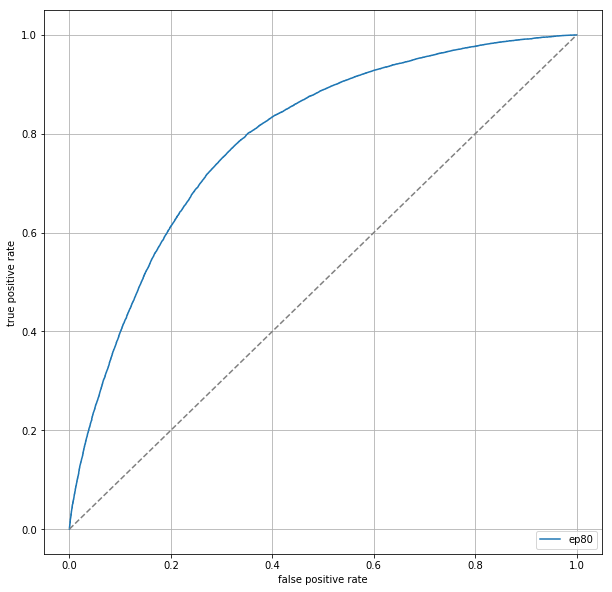

In [16]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(10,10))
fpr, tpr, _ = roc_curve(preds[:,1], preds[:,0])
plt.plot(fpr, tpr, label=mod_name.split('_')[0])
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),color='grey',linestyle='--')
plt.grid()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

# Best ROC AUC on test: 0.7889